# Setup

In [2]:
import plotly.io as pio
try:
    import google.colab
    print("Running as a Colab notebook")
    pio.renderers.default = "colab"
    %pip install transformer-lens fancy-einsum
    %pip install -U kaleido # kaleido only works if you restart the runtime. Required to write figures to disk (final cell)
except:
    print("Running as a Jupyter notebook")
    pio.renderers.default = "vscode"
    from IPython import get_ipython
    ipython = get_ipython()

Running as a Jupyter notebook


In [3]:
import torch
from fancy_einsum import einsum
from transformer_lens import HookedTransformer, HookedTransformerConfig, utils, ActivationCache
from torchtyping import TensorType as TT
import plotly.express as px
import plotly.graph_objects as go
import numpy as np
import einops
from typing import List, Union, Optional
from functools import partial
import pandas as pd
from pathlib import Path
import urllib.request
from bs4 import BeautifulSoup
from tqdm import tqdm
from datasets import load_dataset
import os
import json

os.environ["TOKENIZERS_PARALLELISM"] = "false" # https://stackoverflow.com/q/62691279
torch.set_grad_enabled(False)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

In [4]:
!pip install circuitsvis
import circuitsvis as cv


[notice] A new release of pip is available: 23.0.1 -> 23.1.2
[notice] To update, run: pip install --upgrade pip


In [5]:
pio.renderers.default='vscode'

def imshow(tensor, renderer=None, **kwargs):
    px.imshow(utils.to_numpy(tensor), color_continuous_midpoint=0.0, color_continuous_scale="RdBu", **kwargs).show(renderer)

def line(tensor, renderer=None, **kwargs):
    px.line(y=utils.to_numpy(tensor), **kwargs).show(renderer)

def scatter(x, y, xaxis="", yaxis="", caxis="", renderer=None, **kwargs):
    x = utils.to_numpy(x)
    y = utils.to_numpy(y)
    px.scatter(y=y, x=x, labels={"x":xaxis, "y":yaxis, "color":caxis}, **kwargs).show(renderer)

In [83]:
model = HookedTransformer.from_pretrained(
    "gpt2-large",
    center_unembed=True,
    center_writing_weights=True,
    fold_ln=True,
    refactor_factored_attn_matrices=True,
    device=device,
)

Using pad_token, but it is not set yet.


Loaded pretrained model gpt2-large into HookedTransformer


## Generate Prompts For GPT-4 Example Generation

In [6]:
import pickle
with open("data/iteration_prompts_ref_1.pkl", "rb") as f:
    generation_eval = pickle.load(f)

with open("data/head_explanation_1_nh_to_exp.json", "rb") as f:
    nh_to_explanation = json.load(f)

nh_to_explanation = {tuple(int(value.strip()) for value in k.strip('()').split(',')): v for k,v in nh_to_explanation.items()}

with open("data/neuron_finder_results.json", "r") as f:
    neuron_finder_results = json.load(f)

with open("data/head_explanation_1_prompts.json", "r") as f:
    given_categories = json.load(f)

given_categories = {tuple(int(value.strip()) for value in k.strip('()').split(',')): v for k,v in given_categories.items()}

with open("data/categorised_prompts_1.pkl", "rb") as f:
    categorised_prompts = pickle.load(f)


neuron_to_token = {}

for layer in neuron_finder_results.keys():
    for neuron_ind in neuron_finder_results[layer].keys():
        neuron_to_token[(int(layer), int(neuron_ind))] = neuron_finder_results[layer][neuron_ind][0]

with open("data/head_explanation_1_prompts.json", "r") as f:
    max_activating_categorised = json.load(f)

max_activating_categorised = {tuple(int(value.strip()) for value in k.strip('()').split(',')): v for k,v in max_activating_categorised.items()}

In [7]:
# Load Dataset
from activating_dataset import ActivatingDataset

# Load Neuron
# try:
#     dataset = load_dataset("NeelNanda/pile-10k", split="train")
# except: # this is a hack to let me work offline
#     import pickle
#     with open("dataset.pkl", "rb") as f:
#         dataset = pickle.load(f)

import pickle
with open("data/text_list_dict_test.pkl", "rb") as f:
    dataset = pickle.load(f)

# print(dataset[0])

data = ActivatingDataset('data/neuron_20_examples_test.json', dataset)
print(data.markers)
data_markers = {}
# data markers is {key: [[a, b, c, d, e], [a, b, c, d, e]]}
# we want to make it {key: [{'act': a, 'start': b, 'end': c, 'index': d, 'partact': e}, ...]}
data_markers = {key: [{'act': a, 'start': b, 'end': c, 'index': d, 'partact': e} for a, b, c, d, e in value] for key, value in data.markers.items()}
data.markers = data_markers

data.remove_prompts_longer_than(100)
neurons = list(data.markers.keys())

{(31, 3621): [[10.251951217651367, 867, 961, 510, 8.210393905639648], [10.188377380371094, 310, 315, 418, 9.43882942199707], [10.177841186523438, 438, 603, 520, 7.3954033851623535], [9.966235160827637, 464, 731, 5317, 3.7133500576019287], [9.487281799316406, 409, 414, 2899, 6.246142387390137], [9.439425468444824, 113, 156, 7545, 6.262213230133057], [9.430610656738281, 174, 232, 4284, 6.710473537445068], [9.34101676940918, 81, 185, 4034, 6.5010480880737305], [9.274694442749023, 110, 125, 7126, 7.18107795715332], [9.274541854858398, 112, 117, 2018, 6.246142387390137], [9.186296463012695, 4, 9, 9169, 6.246142387390137], [8.998616218566895, 133, 283, 1496, 7.681527137756348], [8.982619285583496, 49, 114, 3843, 6.47260046005249], [8.976102828979492, 323, 449, 7196, 6.426324367523193], [8.974493026733398, 195, 200, 200, 6.088919639587402], [8.886434555053711, 983, 991, 3751, 7.5927300453186035], [8.856136322021484, 266, 400, 1894, 7.205070495605469], [8.831971168518066, 623, 700, 1005, 8.010

In [8]:
with open("data/head_attribution_dict_test.json", "r") as f:
    head_attribution_dict = json.load(f)

In [10]:
from prompt_generators import ClassifyPromptGen

In [11]:
nh_list = list(nh_to_explanation.keys())
prompt_to_nh = {}

for nh in nh_list:
    neuron = (nh[0], nh[1])
    token = neuron_to_token[neuron]

    example_list = list(head_attribution_dict[str(neuron)].keys())
    example_list = [example + token for example in example_list]

    explanation = nh_to_explanation[nh]

    for example in example_list:

        prompt_gen = ClassifyPromptGen(example=example, token=token, explanation_str=explanation)
        prompt = prompt_gen.get_prompt()
        prompt_to_nh[prompt] = [nh] if prompt not in prompt_to_nh else prompt_to_nh[prompt] + [nh]

print(len(prompt_to_nh))

2812


In [12]:
with open('data/eg_classify_1_results.jsonl', 'r') as json_file:
    classification_results = list(json_file)

In [13]:
prompt_to_response = {}
# neuron_head_to_response = {}
# neuron_head_to_prompt = prompt
# neuron_heads = list(neuron_head_to_prompt.keys())

for i, json_str in enumerate(classification_results):
    result = json.loads(json_str)
    prompt = result[0]["messages"][0]["content"]
    response = result[1]["choices"][0]["message"]["content"]
    prompt_to_response[prompt] = response

In [107]:
nh_to_results = {}
# Here are the variables
nh_to_egs = {}
nh_to_relevant_mask = {}
for nh in nh_list:
    neuron, head = (nh[0], nh[1]), nh[2]
    token = neuron_to_token[neuron]
    relevant_prompts = [prompt for prompt in prompt_to_response.keys() if nh in prompt_to_nh[prompt]]
    # relevant_prompts = list(prompt_to_response.keys())
    relevant_egs = [prompt.split('"""')[1][1:-1-len(token)] for prompt in relevant_prompts]
    tn, fn, fp, tp = 0, 0, 0, 0
    nh_to_relevant_mask[nh] = []
    for i, eg in enumerate(relevant_egs):
        # break
        good_heads = head_attribution_dict[str(neuron)][eg]
        response = prompt_to_response[relevant_prompts[i]]
        if head in good_heads:
            nh_to_relevant_mask[nh].append(1)
            if response == "Yes":
                tp += 1
            elif response == "No":
                fn += 1
            else:
                raise Exception("Response is not Yes or No!")
        else:
            nh_to_relevant_mask[nh].append(0)
            if response == "Yes":
                fp += 1
            elif response == "No":
                tn += 1
            else:
                raise Exception("Response is not Yes or No!")
    nh_to_results[nh] = {"tn":tn, "fn":fn, "fp":fp, "tp":tp}
    nh_to_egs[nh] = relevant_egs

In [71]:
# Sort nh_to_results by by accuracy
nh_to_tpr = {nh: nh_to_results[nh]["tp"] / (nh_to_results[nh]["tp"] + nh_to_results[nh]["fn"])  if nh_to_results[nh]["tp"] + nh_to_results[nh]["fn"] != 0 else None for nh in nh_list}
nh_to_tnr = {nh: nh_to_results[nh]["tn"] / (nh_to_results[nh]["tn"] + nh_to_results[nh]["fp"]) if nh_to_results[nh]["tn"] + nh_to_results[nh]["fp"] != 0 else None for nh in nh_list}

nh_to_tpr_tnr_avg = {}
for nh in nh_list:
    tpr = nh_to_tpr[nh]
    tnr = nh_to_tnr[nh]
    # If one is none, then the average is the other
    if tpr is None:
        nh_to_tpr_tnr_avg[nh] = tnr
    elif tnr is None:
        nh_to_tpr_tnr_avg[nh] = tpr
    else:
        nh_to_tpr_tnr_avg[nh] = (tpr + tnr) / 2

# nh_to_tpr_tnr_avg_no_None = {k: v for k, v in nh_to_tpr_tnr_avg.items() if v is not None}
# nh_to_accuracy = {nh: (nh_to_results[nh]["tp"] + nh_to_results[nh]["tn"]) / (nh_to_results[nh]["tp"] + nh_to_results[nh]["tn"] + nh_to_results[nh]["fp"] + nh_to_results[nh]["fn"]) for nh in nh_list}
# nh_to_accuracy = {k: v for k, v in sorted(nh_to_accuracy.items(), key=lambda item: item[1], reverse=True)}
# nh_list_sorted_by_accuracy = list(nh_to_accuracy.keys())
nh_to_tpr_tnr_avg = {k: v for k, v in sorted(nh_to_tpr_tnr_avg.items(), key=lambda item: item[1], reverse=True)}
nh_list_sorted_by_head_eval_score = list(nh_to_tpr_tnr_avg.keys())

Text(0, 0.5, 'Number of Heads')

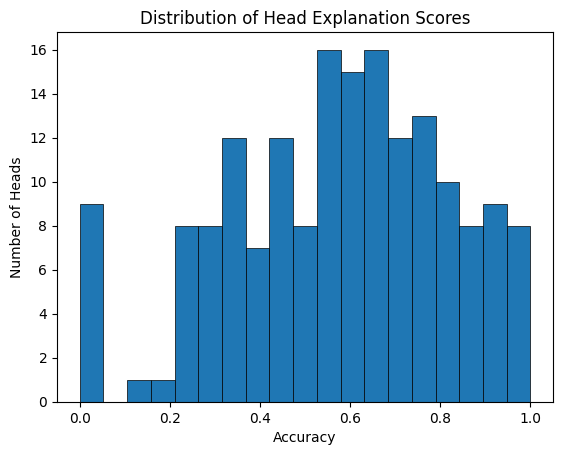

In [140]:
# for nh in nh_list_sorted_by_head_eval_score:
    # print(nh, nh_to_tpr_tnr_avg[nh])

nh_to_f1 = {nh: 2 * nh_to_results[nh]["tp"] / (2 * nh_to_results[nh]["tp"] + nh_to_results[nh]["fp"] + nh_to_results[nh]["fn"]) if nh_to_results[nh]["tp"] + nh_to_results[nh]["fp"] + nh_to_results[nh]["fn"] != 0 else None for nh in nh_list}
nh_list_sorted_by_f1 = list(nh_to_f1.keys())

# Filter out None in f1 values
f1_values = [nh_to_f1[nh] for nh in nh_to_f1 if nh_to_f1[nh] is not None]

bins = np.linspace(0, 1, 20)
import matplotlib.pyplot as plt
plt.hist(f1_values, bins, label='Overall Accuracy', linewidth=0.5, edgecolor="black")
plt.title("Distribution of Head Explanation Scores")
plt.xlabel("Accuracy")
plt.ylabel("Number of Heads")

In [16]:
save_results = False

if save_results:
    # Save results
    nh_to_results_str_key = {str(k): v for k, v in nh_to_results.items()}
    with open("data/nh_to_results_test.json", "w") as f:
        json.dump(nh_to_results_str_key, f)


    nh_to_egs_str_key = {str(k): v for k, v in nh_to_egs.items()}
    with open("data/nh_to_egs_test.json", "w") as f:
        json.dump(nh_to_egs_str_key, f)

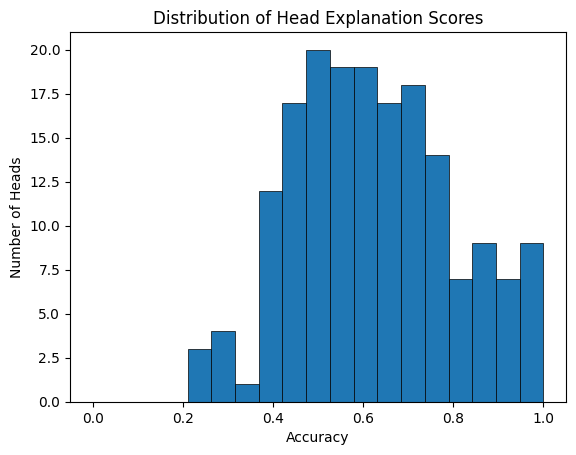

In [79]:
bins = np.linspace(0, 1, 20)
import matplotlib.pyplot as plt
plt.hist(nh_to_tpr_tnr_avg.values(), bins, label='Overall Accuracy', linewidth=0.5, edgecolor="black")
plt.title("Distribution of Head Explanation Scores")
plt.xlabel("Accuracy")
plt.ylabel("Number of Heads")
if save_results:
    plt.savefig("hist_NA_tnr_tpr_ignored.pdf")
    save_results = False

In [18]:
bins = np.linspace(0, 1, 20)
import matplotlib.pyplot as plt
plt.hist(tpr_list, bins, label='Overall Accuracy', linewidth=0.5, edgecolor="black")
plt.title("Distribution of TPR")
plt.xlabel("Accuracy")
plt.ylabel("Number of Heads")

NameError: name 'tpr_list' is not defined

[(0.125, 0.8), (0.1111111111111111, 0.75), (0.8, 1.0), (0.1, 1.0), (0.5555555555555556, 1.0), (0.9285714285714286, 1.0), (0.8, 0.9), (0.42857142857142855, 0.6666666666666666), (0.1111111111111111, 1.0), (1.0, 1.0), (1.0, 0.5), (0.4, 1.0), (0.375, 1.0), (0.9230769230769231, 0.25), (0.7333333333333333, 0.5), (0.8125, 1.0), (1.0, 1.0), (0.7142857142857143, 0.9), (0.6666666666666666, 1.0), (0.5384615384615384, 1.0), (0.5, 0.0), (0.7222222222222222, 1.0), (0.4, 0.4), (0.5882352941176471, 0.6666666666666666), (0.7857142857142857, 0.6666666666666666), (0.25, 0.5833333333333334), (0.0, 0.8461538461538461), (0.5454545454545454, 1.0), (0.2222222222222222, 1.0), (0.4, 0.8888888888888888), (0.5833333333333334, 0.5714285714285714), (0.25, 0.8571428571428571), (0.0, 0.8421052631578947), (0.3333333333333333, 0.5714285714285714), (0.0, 1.0), (0.8333333333333334, 0.38461538461538464), (0.6, 1.0), (0.4666666666666667, 0.75), (0.7647058823529411, 1.0), (0.4666666666666667, 1.0), (0.0, 1.0), (0.0, 0.94736

[Text(0.5, 1.0, 'Distribution of True Positive and True Negative Rates over all heads\n')]

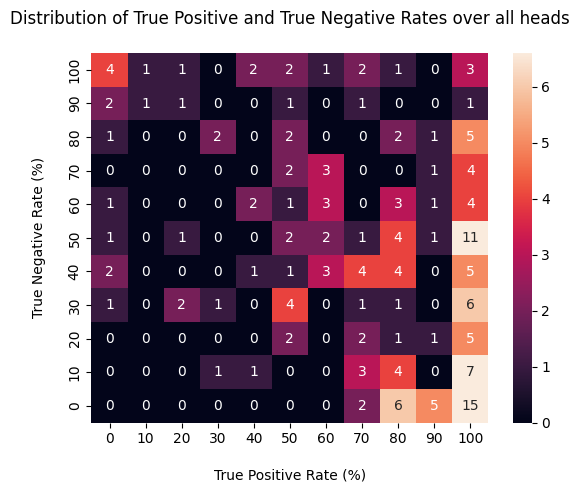

In [74]:
tnr = lambda nh: nh_to_results[nh]["tn"] / (nh_to_results[nh]["tn"] + nh_to_results[nh]["fp"]) if nh_to_results[nh]["tn"] + nh_to_results[nh]["fp"] > 0 else 0
tpr = lambda nh: nh_to_results[nh]["tp"] / (nh_to_results[nh]["tp"] + nh_to_results[nh]["fn"]) if nh_to_results[nh]["tp"] + nh_to_results[nh]["fn"] > 0 else 0

x = tnr_list = [tnr(nh) for nh in nh_list]
y = tpr_list = [tpr(nh) for nh in nh_list]


import seaborn as sb

# Create a 2D array filled with zeros
grid = np.zeros((11, 11), dtype=int)

# Iterate through the values in x and y
zipped_list = list(zip(x, y))
print(zipped_list)
for x_item, y_item in zipped_list:
    # Iterate through the values in x and y
    # Increment the count in the grid at the corresponding position
    grid[int(x_item*10), int(y_item*10)] +=  1


ax = sb.heatmap(grid, annot=True, robust=True, xticklabels=[i*10 for i in range(11)], yticklabels=[i*10 for i in range(11)])
ax.invert_yaxis()
ax.set(xlabel="\nTrue Positive Rate (%)", ylabel="True Negative Rate (%)\n")
ax.set(title="Distribution of True Positive and True Negative Rates over all heads\n")

## Printing

In [106]:
# load nh_to_egs_results.json
with open("data/nh_to_egs_results.json", "r") as f:
    nh_to_egs_results = json.load(f)

# Convert keys, which are '(a, b, c)', to tuple
nh_to_egs_results = {eval(k): v for k, v in nh_to_egs_results.items()}
print(nh_to_egs_results)


{(31, 3621, 468): {'tp': ['41, the Eagle is New York City’s only daily devoted exclusively to Brooklyn.  The Brooklyn Daily Eagle and brooklyneagle.com cover Brooklyn 24/7 online and five days a week in print with the motto, “All Brooklyn All the Time.” With a history dating back to 1841, the Eagle is New York City’s', " for clarity only. Optimized only if necessary.  No one cares if your function thats called once a month takes an extra few seconds to run.  ~~~ sbov > I'll go one step further... all new code should be written for clarity", ' we not only get people back to work, but we also make sure that they’re trained up for the long term,” says Mayor Ron Nirenberg, shown in this April 16, 2020, photo.  “There’s already some good discussions underway about making we sure that we not', "  may only appear once in this section.> Then I try to build the solution then  I'm getting error on Output Error CS1029 error: 'Generation error: The element  may"], 'fp': [' one chance and one chanc

In [124]:
def get_printout():
    return_str = ""

    for nh in nh_list_sorted_by_head_eval_score:
        token = neuron_to_token[(nh[0], nh[1])]
        return_str += f"{nh}, '{token}', {nh_to_tpr_tnr_avg[nh]}\n"
        return_str += f"This head is active when {nh_to_explanation[nh]}.\n"
        results = nh_to_egs_results[nh]
        tp, tn, fp, fn = results['tp'], results['tn'], results['fp'], results['fn']
        return_str += "Examples where the head is active:\n"
        for eg in results['tp']:
            return_str += f"✅ {eg + token}\n"
        for eg in results['fp']:
            return_str += f"❌ {eg + token}\n"

        return_str += "Examples where the head is inactive:\n"
        for eg in results['tn']:
            return_str += f"✅ {eg + token}\n"
        for eg in results['fn']:
            return_str += f"❌ {eg + token}\n"
        return_str += "\n"

    return return_str

with open("eval_results.txt", "w") as f:
    f.write(get_printout())


            return_str += "✅ "
        else:
            return_str += "❌ "

In [81]:
# Get mean of accuracy diff
# remove nan
nh_list_diff_between_relevant_and_irrelevant = {k:v for k,v in nh_list_diff_between_relevant_and_irrelevant.items() if not np.isnan(v)}

list_diff = list(nh_list_diff_between_relevant_and_irrelevant.values())
mean = sum(list_diff) / len(list_diff)
print(mean)

NameError: name 'nh_list_diff_between_relevant_and_irrelevant' is not defined

In [ ]:
for x in nh_list_sorted_by_head_eval_score:
    print(x)

In [86]:
print(nh_to_egs)

{(31, 3621, 468): {'tp': ['41, the Eagle is New York City’s only daily devoted exclusively to Brooklyn.  The Brooklyn Daily Eagle and brooklyneagle.com cover Brooklyn 24/7 online and five days a week in print with the motto, “All Brooklyn All the Time.” With a history dating back to 1841, the Eagle is New York City’s', " for clarity only. Optimized only if necessary.  No one cares if your function thats called once a month takes an extra few seconds to run.  ~~~ sbov > I'll go one step further... all new code should be written for clarity", ' we not only get people back to work, but we also make sure that they’re trained up for the long term,” says Mayor Ron Nirenberg, shown in this April 16, 2020, photo.  “There’s already some good discussions underway about making we sure that we not', "  may only appear once in this section.> Then I try to build the solution then  I'm getting error on Output Error CS1029 error: 'Generation error: The element  may"], 'fp': [' one chance and one chanc

In [87]:
# nh_to_eg is nh:{'tp': [prompt, prompt], 'tn': [prompt, prompt], 'fp': [prompt, prompt], 'fn': [prompt, prompt]}...
# make nh_to_eg_list, which is nh:[prompt, prompt, prompt, prompt]...

nh_to_eg_list = {}
for nh in nh_to_egs:
    nh_to_eg_list[nh] = []
    for key in nh_to_egs[nh]:
        nh_to_eg_list[nh] += nh_to_egs[nh][key]

In [113]:
for nh in nh_list_sorted_by_head_eval_score:
    print(nh)
    print(nh_to_egs[nh][4])
    print(neuron_to_token[(nh[0], nh[1])])
    print(nh_to_explanation[nh])
    print(nh_to_relevant_mask[nh])
    break

(31, 2918, 505)
 while baseball stadiums can come and
 go
contains the phrase "come and go" or variations of it, which implies a focus on things or events that happen temporarily, periodically, or cyclically. In these active examples, the attention head is likely picking up on the idea of change or transience. In the inactive examples, the phrase "come and go" or similar variations are not present, and instead, the word "go" is used in different contexts (such as comparisons, movement, or progress). As a result, the attention head is not active since the context it specializes in is not relevant in these examples.
[0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0]


In [184]:
nh_neuron_acts_attn_ablated_vs_normal = {}

for nh in tqdm(nh_list_sorted_by_head_eval_score):
    model.reset_hooks()
    neuron, head = (nh[0], nh[1]), nh[2]

    prompts = nh_to_egs[nh]

    # def return_ablation_hook(layer, head):
    #     def hook(module, input, output):
    #         output[:, :, head, :] = 0
    #         return output
    #     return hook
    head_index_to_ablate = head%20
    layer_to_ablate = head//20

    def ablation_hook(value, hook):
        value[:, :, head_index_to_ablate, :] = 0

    cache = []

    def return_caching_hook(neuron):
        layer, neuron_index = neuron
        def caching_hook(act, hook):
            cache.append(act[:, :, neuron_index]) # act shape is (batch_size, seq_len, neuron_index)
        return caching_hook
    
    hooks_mlp = list(((f"blocks.{layer}.mlp.hook_post", return_caching_hook((layer, index))) for layer, index in [neuron]))

    x = model.run_with_hooks(
        model.to_tokens(prompts).to(device),
        # fwd_hooks=hooks,
        fwd_hooks = [(utils.get_act_name("v", layer_to_ablate), ablation_hook)] + hooks_mlp
    )

    # Get the activation of the neuron
    tokens = model.to_tokens(prompts)

    pad_token = bos_token = 50256 # This is true for GPT-2
    prompt_lengths = (torch.logical_and(tokens != pad_token, tokens != bos_token)).sum(dim=-1)

    neuron_acts = cache[0]
    # neuron_acts = tokens
    # print(neuron_acts.shape)

    # Create indices to gather the last elements
    batch_size = neuron_acts.size(0)
    max_length = neuron_acts.size(1)
    last_indices = prompt_lengths  # Subtract 1 to get the last element index

    # Create indices tensor to gather from neuron_acts
    indices = torch.arange(0, batch_size) * max_length + last_indices.unsqueeze(1)

    # Gather the last elements from neuron_acts
    head_output_last_seq = torch.gather(neuron_acts.view(-1), 0, indices.view(-1))
    head_output_last_seq = head_output_last_seq.view(batch_size, -1)
    head_output_last_seq = torch.diag(head_output_last_seq)

    ablated_activation = head_output_last_seq.tolist()

    model.reset_hooks()

    cache = []
    x = model.run_with_hooks(
        model.to_tokens(prompts).to(device),
        # fwd_hooks=hooks,
        fwd_hooks = hooks_mlp
    )

    # Get the activation of the neuron
    tokens = model.to_tokens(prompts)

    pad_token = bos_token = 50256 # This is true for GPT-2
    prompt_lengths = (torch.logical_and(tokens != pad_token, tokens != bos_token)).sum(dim=-1)

    neuron_acts = cache[0]
    # neuron_acts = tokens
    # print(neuron_acts.shape)

    # Create indices to gather the last elements
    batch_size = neuron_acts.size(0)
    max_length = neuron_acts.size(1)
    last_indices = prompt_lengths  # Subtract 1 to get the last element index

    # Create indices tensor to gather from neuron_acts
    indices = torch.arange(0, batch_size) * max_length + last_indices.unsqueeze(1)

    # Gather the last elements from neuron_acts
    head_output_last_seq = torch.gather(neuron_acts.view(-1), 0, indices.view(-1))
    head_output_last_seq = head_output_last_seq.view(batch_size, -1)
    head_output_last_seq = torch.diag(head_output_last_seq)

    normal_activation = head_output_last_seq.tolist()

    act_normal_relevant = [normal_activation[i] for i in range(len(normal_activation)) if nh_to_relevant_mask[nh][i] == 1]
    act_normal_irrelevant = [normal_activation[i] for i in range(len(normal_activation)) if nh_to_relevant_mask[nh][i] == 0]

    act_ablate_relevant = [ablated_activation[i] for i in range(len(ablated_activation)) if nh_to_relevant_mask[nh][i] == 1]
    act_ablate_irrelevant = [ablated_activation[i] for i in range(len(ablated_activation)) if nh_to_relevant_mask[nh][i] == 0]


    act_diff_relevant = np.mean(np.array(act_normal_relevant) - np.array(act_ablate_relevant))
    act_diff_irrelevant = np.mean(np.array(act_normal_irrelevant) - np.array(act_ablate_irrelevant))


    nh_neuron_acts_attn_ablated_vs_normal[nh] = {"ablated": ablated_activation, "normal": normal_activation, 'act_diff_relevant': act_diff_relevant, 'act_diff_irrelevant': act_diff_irrelevant}

  0%|          | 0/176 [00:00<?, ?it/s]

  1%|          | 2/176 [00:14<19:53,  6.86s/it]/Users/clementneo/projects/aan/aan/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning:

Mean of empty slice.

/Users/clementneo/projects/aan/aan/lib/python3.10/site-packages/numpy/core/_methods.py:192: RuntimeWarning:

invalid value encountered in scalar divide

100%|██████████| 176/176 [16:08<00:00,  5.51s/it]


In [ ]:
save_file = False

In [203]:
# pickle nh_neuron_acts_attn_ablated_vs_normal
if save_file:
    with open(f"data/nh_neuron_acts_attn_ablated_vs_normal_noabs.pkl", "wb") as f:
        pickle.dump(nh_neuron_acts_attn_ablated_vs_normal, f)
    save_file = False

In [186]:
# Get the average of act_diff_relevant and act_diff_irrelevant
act_diff_relevant = []
act_diff_irrelevant = []
for nh in nh_list_sorted_by_head_eval_score:
    try:
        act_diff_relevant.append(nh_neuron_acts_attn_ablated_vs_normal[nh]['act_diff_relevant'])
        act_diff_irrelevant.append(nh_neuron_acts_attn_ablated_vs_normal[nh]['act_diff_irrelevant'])
    except:
        continue
# act_diff_relevant = [nh_neuron_acts_attn_ablated_vs_normal[nh]['act_diff_relevant'] for nh in nh_list_sorted_by_accuracy]
# act_diff_irrelevant = [nh_neuron_acts_attn_ablated_vs_normal[nh]['act_diff_irrelevant'] for nh in nh_list_sorted_by_accuracy]

print(act_diff_relevant)
print(act_diff_irrelevant)
print(np.mean([x for x in act_diff_relevant if not np.isnan(x)]))
print(np.mean([x for x in act_diff_irrelevant if not np.isnan(x)]))

[0.8071651458740234, -0.01142087849703702, nan, nan, nan, 0.19099664688110352, 0.03542999029159546, 0.31743478775024414, 0.3809674664547569, 0.17890410953097874, 1.3123883141411676, 0.17278623580932617, 0.4698856472969055, 0.40875037511189777, 0.4084061086177826, 0.30119494387978, 0.28740835189819336, 0.2393937110900879, 0.2694859504699707, -0.012598991394042969, 0.8205261911664691, 0.6414600099836077, 0.10729589462280273, 0.9931236902872721, 0.4541449546813965, 0.07404947280883789, 0.05167587101459503, 0.13442420959472656, -0.025391483306884767, 0.051068782806396484, -0.009144020080566407, 0.07407088279724121, 0.43636059761047363, 0.09772205352783203, 0.17031776905059814, -0.036258697509765625, 0.08929405212402344, -0.007005258039994674, 0.19668695330619812, 0.17824452263968332, 0.11727309226989746, 0.24089765548706055, 0.1682344436645508, 0.22054331643240793, 0.15457477569580078, 0.27718329429626465, 0.09732913970947266, 0.23397183418273926, 0.07021284103393555, 0.26879215240478516, 

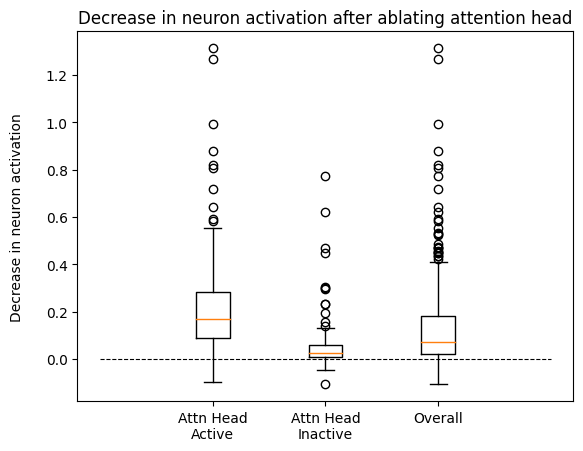

In [200]:
nan_filtered_act_diff_relevant = [x for x in act_diff_relevant if not np.isnan(x)]
nan_filtered_act_diff_irrelevant = [x for x in act_diff_irrelevant if not np.isnan(x)]
# Box plot act_diff_relevant, act_diff_irrelevant, and both combined
plt.boxplot([nan_filtered_act_diff_relevant, nan_filtered_act_diff_irrelevant, nan_filtered_act_diff_relevant + nan_filtered_act_diff_irrelevant], labels=['Attn Head\nActive', 'Attn Head\nInactive', 'Overall'])
plt.ylabel('Decrease in neuron activation\n')
# draw a dotted line at y=0
plt.plot([0, 4], [0, 0], 'k--', linewidth=0.8)
plt.title('Decrease in neuron activation after ablating attention head')
# plt.savefig('ablation_noabs_fixed.pdf')

In [178]:
nh_token_prob_attn_ablated_vs_normal = {}

for nh in tqdm(nh_list_sorted_by_head_eval_score):
    model.reset_hooks()
    neuron, head = (nh[0], nh[1]), nh[2]
    token = neuron_to_token[neuron]

    prompts = nh_to_egs[nh]

    # def return_ablation_hook(layer, head):
    #     def hook(module, input, output):
    #         output[:, :, head, :] = 0
    #         return output
    #     return hook
    head_index_to_ablate = head%20
    layer_to_ablate = head//20

    def ablation_hook(value, hook):
        value[:, :, head_index_to_ablate, :] = 0


    x = model.run_with_hooks(
        model.to_tokens(prompts).to(device),
        # fwd_hooks=hooks,
        fwd_hooks = [(utils.get_act_name("v", layer_to_ablate), ablation_hook)]
    )
    # Softmax x, according to the token index
    x = torch.softmax(x, dim=-1)
    token_index = model.tokenizer.encode(token)[0]
    print(token_index)
    x = x[:, :, token_index]

    # Get the activation of the neuron
    tokens = model.to_tokens(prompts)

    pad_token = bos_token = 50256 # This is true for GPT-2
    prompt_lengths = (torch.logical_and(tokens != pad_token, tokens != bos_token)).sum(dim=-1)

    # neuron_acts = tokens
    # print(neuron_acts.shape)
    # x = tokens

    # Create indices to gather the last elements
    batch_size = x.size(0)
    max_length = x.size(1)
    last_indices = prompt_lengths  # Subtract 1 to get the last element index

    # Create indices tensor to gather from neuron_acts
    indices = torch.arange(0, batch_size) * max_length + last_indices.unsqueeze(1)


    # Gather the last elements from neuron_acts
    head_output_last_seq = torch.gather(x.view(-1), 0, indices.view(-1))
    head_output_last_seq = head_output_last_seq.view(batch_size, -1)
    head_output_last_seq = torch.diag(head_output_last_seq)

    ablated_probs = head_output_last_seq# .tolist()

    model.reset_hooks()

    x = model(model.to_tokens(prompts).to(device))
    # Softmax x, according to the token index
    x = torch.softmax(x, dim=-1)
    token_index = model.tokenizer.encode(token)[0]
    print(token_index)
    x = x[:, :, token_index]

    # Get the activation of the neuron
    tokens = model.to_tokens(prompts)

    pad_token = bos_token = 50256 # This is true for GPT-2
    prompt_lengths = (torch.logical_and(tokens != pad_token, tokens != bos_token)).sum(dim=-1)

    # neuron_acts = tokens
    # print(neuron_acts.shape)
    # x = tokens

    # Create indices to gather the last elements
    batch_size = x.size(0)
    max_length = x.size(1)
    last_indices = prompt_lengths  # Subtract 1 to get the last element index

    # Create indices tensor to gather from neuron_acts
    indices = torch.arange(0, batch_size) * max_length + last_indices.unsqueeze(1)


    # Gather the last elements from neuron_acts
    head_output_last_seq = torch.gather(x.view(-1), 0, indices.view(-1))
    head_output_last_seq = head_output_last_seq.view(batch_size, -1)
    head_output_last_seq = torch.diag(head_output_last_seq)

    normal_probs = head_output_last_seq# .tolist()

    prob_normal_relevant = [normal_probs[i] for i in range(len(normal_probs)) if nh_to_relevant_mask[nh][i] == 1]
    prob_normal_irrelevant = [normal_probs[i] for i in range(len(normal_probs)) if nh_to_relevant_mask[nh][i] == 0]

    prob_ablate_relevant = [ablated_probs[i] for i in range(len(ablated_probs)) if nh_to_relevant_mask[nh][i] == 1]
    prob_ablate_irrelevant = [ablated_probs[i] for i in range(len(ablated_probs)) if nh_to_relevant_mask[nh][i] == 0]


    # prob_diff_relevant = np.mean(np.abs(np.array(prob_normal_relevant) - np.array(prob_ablate_relevant)))
    # prob_diff_irrelevant = np.mean(np.abs(np.array(prob_normal_irrelevant) - np.array(prob_ablate_irrelevant)))
    prob_diff_relevant = np.mean(np.array(prob_normal_relevant) - np.array(prob_ablate_relevant))
    prob_diff_irrelevant = np.mean(np.array(prob_normal_irrelevant) - np.array(prob_ablate_irrelevant))


    nh_token_prob_attn_ablated_vs_normal[nh] = {"ablated": ablated_probs, "normal": normal_probs, 'act_diff_relevant': prob_diff_relevant, 'act_diff_irrelevant': prob_diff_irrelevant}

  0%|          | 0/176 [00:00<?, ?it/s]

467


  1%|          | 1/176 [00:18<54:57, 18.84s/it]

467
1978


  1%|          | 2/176 [00:25<34:09, 11.78s/it]

1978
866


/Users/clementneo/projects/aan/aan/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning:

Mean of empty slice.

/Users/clementneo/projects/aan/aan/lib/python3.10/site-packages/numpy/core/_methods.py:192: RuntimeWarning:

invalid value encountered in scalar divide

  2%|▏         | 3/176 [00:35<31:17, 10.85s/it]

866
706


  2%|▏         | 4/176 [00:38<22:48,  7.96s/it]

706
706


  3%|▎         | 5/176 [00:40<16:15,  5.71s/it]

706
739


  3%|▎         | 6/176 [00:46<16:30,  5.82s/it]

739
45544


  4%|▍         | 7/176 [00:56<19:56,  7.08s/it]

45544
1271


  5%|▍         | 8/176 [01:04<20:48,  7.43s/it]

1271
1398


  5%|▌         | 9/176 [01:10<19:25,  6.98s/it]

1398
503


  6%|▌         | 10/176 [01:13<16:03,  5.80s/it]

503
355


  6%|▋         | 11/176 [01:23<19:29,  7.09s/it]

355
1978


  7%|▋         | 12/176 [01:29<18:02,  6.60s/it]

1978
691


  7%|▋         | 13/176 [01:37<19:11,  7.06s/it]

691
612


  8%|▊         | 14/176 [01:42<17:40,  6.55s/it]

612
739


  9%|▊         | 15/176 [01:47<16:17,  6.07s/it]

739
938


  9%|▉         | 16/176 [01:52<14:55,  5.59s/it]

938
355


 10%|▉         | 17/176 [02:02<18:49,  7.10s/it]

355
835


 10%|█         | 18/176 [02:06<15:46,  5.99s/it]

835
706


 11%|█         | 19/176 [02:09<13:52,  5.30s/it]

706
1444


 11%|█▏        | 20/176 [02:12<11:57,  4.60s/it]

1444
625


 12%|█▏        | 21/176 [02:15<10:26,  4.04s/it]

625
625


 12%|█▎        | 22/176 [02:18<09:13,  3.60s/it]

625
1271


 13%|█▎        | 23/176 [02:28<14:03,  5.52s/it]

1271
510


 14%|█▎        | 24/176 [02:35<15:24,  6.08s/it]

510
706


 14%|█▍        | 25/176 [02:39<13:27,  5.35s/it]

706
1978


 15%|█▍        | 26/176 [02:43<12:25,  4.97s/it]

1978
286


 15%|█▌        | 27/176 [02:48<12:20,  4.97s/it]

286
866


 16%|█▌        | 28/176 [02:55<13:47,  5.59s/it]

866
1978


 16%|█▋        | 29/176 [03:00<13:32,  5.53s/it]

1978
835


 17%|█▋        | 30/176 [03:04<12:17,  5.05s/it]

835
736


 18%|█▊        | 31/176 [03:10<12:31,  5.18s/it]

736
706


 18%|█▊        | 32/176 [03:12<10:10,  4.24s/it]

706
612


 19%|█▉        | 33/176 [03:17<10:38,  4.46s/it]

612
645


 19%|█▉        | 34/176 [03:25<13:13,  5.58s/it]

645
691


 20%|█▉        | 35/176 [03:32<13:58,  5.95s/it]

691
625


 20%|██        | 36/176 [03:34<11:37,  4.98s/it]

625
717


 21%|██        | 37/176 [03:42<13:44,  5.93s/it]

717
355


 22%|██▏       | 38/176 [03:51<15:13,  6.62s/it]

355
286


 22%|██▏       | 39/176 [03:55<13:51,  6.07s/it]

286
1444


 23%|██▎       | 40/176 [03:59<11:58,  5.28s/it]

1444
45544


 23%|██▎       | 41/176 [04:07<13:32,  6.02s/it]

45544
467


 24%|██▍       | 42/176 [04:12<13:03,  5.85s/it]

467
645


 24%|██▍       | 43/176 [04:21<14:56,  6.74s/it]

645
645


 25%|██▌       | 44/176 [04:30<16:08,  7.34s/it]

645
1029


 26%|██▌       | 45/176 [04:37<16:15,  7.45s/it]

1029
845


 26%|██▌       | 46/176 [04:44<15:47,  7.28s/it]

845
835


 27%|██▋       | 47/176 [04:47<12:51,  5.98s/it]

835
36173


 27%|██▋       | 48/176 [04:54<13:28,  6.31s/it]

36173
1088


 28%|██▊       | 49/176 [05:03<14:56,  7.06s/it]

1088
1444


 28%|██▊       | 50/176 [05:08<13:44,  6.54s/it]

1444
736


 29%|██▉       | 51/176 [05:17<14:56,  7.17s/it]

736
826


 30%|██▉       | 52/176 [05:21<13:02,  6.31s/it]

826
36173


 30%|███       | 53/176 [05:28<13:22,  6.53s/it]

36173
1029


 31%|███       | 54/176 [05:33<12:01,  5.91s/it]

1029
645


 31%|███▏      | 55/176 [05:38<11:38,  5.77s/it]

645
467


 32%|███▏      | 56/176 [05:42<10:31,  5.26s/it]

467
503


 32%|███▏      | 57/176 [05:45<09:06,  4.59s/it]

503
779


 33%|███▎      | 58/176 [05:50<09:11,  4.67s/it]

779
1181


 34%|███▎      | 59/176 [05:56<09:37,  4.94s/it]

1181
2071


 34%|███▍      | 60/176 [06:02<10:32,  5.45s/it]

2071
1708


 35%|███▍      | 61/176 [06:06<09:05,  4.74s/it]

1708
1969


 35%|███▌      | 62/176 [06:10<09:06,  4.80s/it]

1969
467


 36%|███▌      | 63/176 [06:14<08:20,  4.43s/it]

467
572


 36%|███▋      | 64/176 [06:18<07:53,  4.22s/it]

572
706


 37%|███▋      | 65/176 [06:21<07:18,  3.95s/it]

706
1708


 38%|███▊      | 66/176 [06:24<06:41,  3.65s/it]

1708
779


 38%|███▊      | 67/176 [06:30<07:50,  4.32s/it]

779
1839


 39%|███▊      | 68/176 [06:36<08:39,  4.81s/it]

1839
510


 39%|███▉      | 69/176 [06:42<09:08,  5.13s/it]

510
355


 40%|███▉      | 70/176 [06:51<11:00,  6.24s/it]

355
416


 40%|████      | 71/176 [06:54<09:27,  5.41s/it]

416
572


 41%|████      | 72/176 [06:58<08:26,  4.87s/it]

572
866


 41%|████▏     | 73/176 [07:05<09:24,  5.48s/it]

866
1176


 42%|████▏     | 74/176 [07:08<08:20,  4.91s/it]

1176
572


 43%|████▎     | 75/176 [07:13<08:24,  5.00s/it]

572
973


 43%|████▎     | 76/176 [07:19<08:49,  5.30s/it]

973
286


 44%|████▍     | 77/176 [07:28<10:24,  6.31s/it]

286
881


 44%|████▍     | 78/176 [07:35<10:48,  6.62s/it]

881
1708


 45%|████▍     | 79/176 [07:38<08:59,  5.56s/it]

1708
706


 45%|████▌     | 80/176 [07:43<08:17,  5.19s/it]

706
2071


 46%|████▌     | 81/176 [07:50<09:02,  5.71s/it]

2071
1444


 47%|████▋     | 82/176 [07:53<07:41,  4.91s/it]

1444
383


 47%|████▋     | 83/176 [07:59<08:18,  5.36s/it]

383
1176


 48%|████▊     | 84/176 [08:03<07:21,  4.80s/it]

1176
1398


 48%|████▊     | 85/176 [08:11<08:49,  5.81s/it]

1398
1978


 49%|████▉     | 86/176 [08:16<08:38,  5.76s/it]

1978
973


 49%|████▉     | 87/176 [08:22<08:24,  5.67s/it]

973
2071


 50%|█████     | 88/176 [08:31<09:47,  6.68s/it]

2071
835


 51%|█████     | 89/176 [08:36<09:07,  6.29s/it]

835
835


 51%|█████     | 90/176 [08:42<08:37,  6.01s/it]

835
607


 52%|█████▏    | 91/176 [08:48<08:35,  6.06s/it]

607
1088


 52%|█████▏    | 92/176 [08:55<09:07,  6.52s/it]

1088
779


 53%|█████▎    | 93/176 [09:02<09:06,  6.58s/it]

779
2399


 53%|█████▎    | 94/176 [09:10<09:27,  6.92s/it]

2399
881


 54%|█████▍    | 95/176 [09:15<08:41,  6.44s/it]

881
1839


 55%|█████▍    | 96/176 [09:22<08:33,  6.42s/it]

1839
1978


 55%|█████▌    | 97/176 [09:26<07:49,  5.95s/it]

1978
383


 56%|█████▌    | 98/176 [09:35<08:34,  6.60s/it]

383
1839


 56%|█████▋    | 99/176 [09:43<09:20,  7.28s/it]

1839
938


 57%|█████▋    | 100/176 [09:48<08:02,  6.36s/it]

938
973


 57%|█████▋    | 101/176 [09:54<07:51,  6.29s/it]

973
572


 58%|█████▊    | 102/176 [09:59<07:24,  6.01s/it]

572
612


 59%|█████▊    | 103/176 [10:05<07:14,  5.95s/it]

612
510


 59%|█████▉    | 104/176 [10:13<07:56,  6.62s/it]

510
706


 60%|█████▉    | 105/176 [10:17<06:57,  5.89s/it]

706
546


 60%|██████    | 106/176 [10:23<06:53,  5.91s/it]

546
467


 61%|██████    | 107/176 [10:27<06:08,  5.35s/it]

467
286


 61%|██████▏   | 108/176 [10:36<07:16,  6.42s/it]

286
973


 62%|██████▏   | 109/176 [10:45<08:01,  7.19s/it]

973
691


 62%|██████▎   | 110/176 [10:52<07:39,  6.96s/it]

691
546


 63%|██████▎   | 111/176 [10:59<07:31,  6.94s/it]

546
1271


 64%|██████▎   | 112/176 [11:07<08:02,  7.54s/it]

1271
1398


 64%|██████▍   | 113/176 [11:14<07:26,  7.09s/it]

1398
1398


 65%|██████▍   | 114/176 [11:20<07:02,  6.81s/it]

1398
523


 65%|██████▌   | 115/176 [11:27<07:03,  6.95s/it]

523
607


 66%|██████▌   | 116/176 [11:32<06:29,  6.49s/it]

607
523


 66%|██████▋   | 117/176 [11:39<06:32,  6.65s/it]

523
481


 67%|██████▋   | 118/176 [11:48<06:56,  7.18s/it]

481
845


 68%|██████▊   | 119/176 [11:55<06:49,  7.19s/it]

845
1181


 68%|██████▊   | 120/176 [12:02<06:47,  7.28s/it]

1181
523


 69%|██████▉   | 121/176 [12:12<07:19,  7.98s/it]

523
1626


 69%|██████▉   | 122/176 [12:19<06:49,  7.59s/it]

1626
503


 70%|██████▉   | 123/176 [12:23<05:48,  6.57s/it]

503
1165


 70%|███████   | 124/176 [12:32<06:13,  7.19s/it]

1165
1165


 71%|███████   | 125/176 [12:40<06:20,  7.46s/it]

1165
826


 72%|███████▏  | 126/176 [12:43<05:06,  6.13s/it]

826
503


 72%|███████▏  | 127/176 [12:46<04:13,  5.17s/it]

503
1752


 73%|███████▎  | 128/176 [12:54<04:59,  6.23s/it]

1752
779


 73%|███████▎  | 129/176 [12:59<04:34,  5.84s/it]

779
523


 74%|███████▍  | 130/176 [13:07<04:50,  6.32s/it]

523
1181


 74%|███████▍  | 131/176 [13:14<04:59,  6.66s/it]

1181
1708


 75%|███████▌  | 132/176 [13:19<04:22,  5.96s/it]

1708
1088


 76%|███████▌  | 133/176 [13:25<04:26,  6.19s/it]

1088
938


 76%|███████▌  | 134/176 [13:29<03:48,  5.43s/it]

938
416


 77%|███████▋  | 135/176 [13:32<03:16,  4.80s/it]

416
706


 77%|███████▋  | 136/176 [13:34<02:32,  3.82s/it]

706
2399


 78%|███████▊  | 137/176 [13:41<03:05,  4.75s/it]

2399
45544


 78%|███████▊  | 138/176 [13:46<03:07,  4.93s/it]

45544
503


 79%|███████▉  | 139/176 [13:50<02:56,  4.76s/it]

503
1181


 80%|███████▉  | 140/176 [13:57<03:16,  5.45s/it]

1181
503


 80%|████████  | 141/176 [14:03<03:07,  5.35s/it]

503
546


 81%|████████  | 142/176 [14:09<03:16,  5.77s/it]

546
2399


 81%|████████▏ | 143/176 [14:18<03:39,  6.64s/it]

2399
1165


 82%|████████▏ | 144/176 [14:24<03:28,  6.51s/it]

1165
546


 82%|████████▏ | 145/176 [14:33<03:40,  7.12s/it]

546
691


 83%|████████▎ | 146/176 [14:41<03:44,  7.49s/it]

691
706


 84%|████████▎ | 147/176 [14:44<02:54,  6.00s/it]

706
416


 84%|████████▍ | 148/176 [14:48<02:32,  5.43s/it]

416
1626


 85%|████████▍ | 149/176 [14:54<02:37,  5.83s/it]

1626
383


 85%|████████▌ | 150/176 [15:02<02:46,  6.41s/it]

383
938


 86%|████████▌ | 151/176 [15:10<02:47,  6.71s/it]

938
880


 86%|████████▋ | 152/176 [15:14<02:24,  6.02s/it]

880
1969


 87%|████████▋ | 153/176 [15:19<02:12,  5.76s/it]

1969
691


 88%|████████▊ | 154/176 [15:24<02:01,  5.54s/it]

691
717


 88%|████████▊ | 155/176 [15:31<02:04,  5.91s/it]

717
1626


 89%|████████▊ | 156/176 [15:35<01:49,  5.46s/it]

1626
607


 89%|████████▉ | 157/176 [15:41<01:42,  5.39s/it]

607
717


 90%|████████▉ | 158/176 [15:47<01:41,  5.63s/it]

717
866


 90%|█████████ | 159/176 [15:53<01:38,  5.78s/it]

866
2399


 91%|█████████ | 160/176 [16:00<01:36,  6.06s/it]

2399
826


 91%|█████████▏| 161/176 [16:03<01:19,  5.30s/it]

826
881


 92%|█████████▏| 162/176 [16:09<01:15,  5.37s/it]

881
1444


 93%|█████████▎| 163/176 [16:13<01:04,  4.96s/it]

1444
607


 93%|█████████▎| 164/176 [16:19<01:05,  5.42s/it]

607
1969


 94%|█████████▍| 165/176 [16:28<01:09,  6.28s/it]

1969
845


 94%|█████████▍| 166/176 [16:34<01:03,  6.38s/it]

845
739


 95%|█████████▍| 167/176 [16:39<00:53,  5.96s/it]

739
546


 95%|█████████▌| 168/176 [16:45<00:46,  5.82s/it]

546
383


 96%|█████████▌| 169/176 [16:51<00:41,  5.86s/it]

383
866


 97%|█████████▋| 170/176 [16:57<00:37,  6.18s/it]

866
481


 97%|█████████▋| 171/176 [17:03<00:30,  6.09s/it]

481
881


 98%|█████████▊| 172/176 [17:10<00:25,  6.36s/it]

881
1708


 98%|█████████▊| 173/176 [17:14<00:16,  5.41s/it]

1708
1444


 99%|█████████▉| 174/176 [17:16<00:09,  4.65s/it]

1444
1752


 99%|█████████▉| 175/176 [17:25<00:05,  5.82s/it]

1752
2071


100%|██████████| 176/176 [17:32<00:00,  5.98s/it]

2071


In [181]:
# pickle nh_token_prob_attn_ablated_vs_normal
if save_results:
    with open('data/nh_token_prob_attn_ablated_vs_normal_noabs.pkl', 'wb') as f:
        pickle.dump(nh_token_prob_attn_ablated_vs_normal, f)
    save_results = False

0.008473633 0.014158177
0.00086165854 0.0046036523


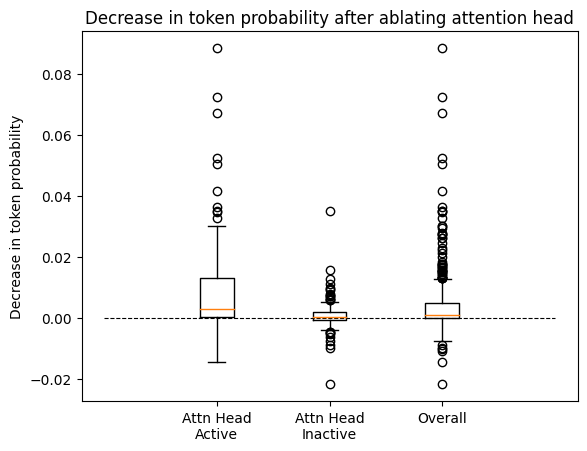

In [202]:
# Calculate the difference 
nh_token_prob_attn_ablated_vs_normal_diff = {}

relevant_list, irrelevant_list = [], []
for nh in nh_list_sorted_by_head_eval_score:
    prob_diff_relevant = nh_token_prob_attn_ablated_vs_normal[nh]["act_diff_relevant"]
    prob_diff_irrelevant = nh_token_prob_attn_ablated_vs_normal[nh]["act_diff_irrelevant"]
    if not np.isnan(prob_diff_relevant):
        relevant_list.append(prob_diff_relevant)
    if not np.isnan(prob_diff_irrelevant):
        irrelevant_list.append(prob_diff_irrelevant)
# diff_list = list(nh_token_prob_attn_ablated_vs_normal_diff.values())


# print(len(diff_list))
# print(np.mean(diff_list), np.std(diff_list))
print(np.mean(relevant_list), np.std(relevant_list))
print(np.mean(irrelevant_list), np.std(irrelevant_list))

# scatter(np.arange(len(diff_list)), diff_list)
plt.boxplot((relevant_list, irrelevant_list, relevant_list + irrelevant_list), labels=['Attn Head\nActive', 'Attn Head\nInactive', 'Overall'])
plt.ylabel("Decrease in token probability")
plt.plot([0, 4], [0, 0], linestyle='--', color='k', linewidth=0.8)
plt.title("Decrease in token probability after ablating attention head")
# draw a dotted line at y=0
# plt.savefig("ablation_token_prob_noabs_fixed.pdf")

In [33]:
softmaxed_saved = softmaxed

In [ ]:
check_if_responses_can_be_processed = False # Do this first
iteration_prompts = {}
iteration_prompts_ref = {}

for i, (neuron_head, generated_example) in tqdm(enumerate(generated_examples.items())):
    neuron, head_no = (neuron_head[0], neuron_head[1]), neuron_head[2]
    relevant_token = neuron_to_token[neuron]

    capitalised_token = relevant_token[0] + relevant_token[1].capitalize() + relevant_token[2:] # we can do this because by definition we got " word" tokens
    
    if 'is_inactive' in generated_example:
        generated_example = generated_example.replace('is_inactive', 'is inactive') # For some reason this was in one prompt

    # Extract the positive and negative examples. 
    def get_list_of_strings(string):
        return [s[3:] if s[1] == "." else s[4:] for s in string.split("\n") if s != ''] # Wonky but it works

    positive_examples = generated_example.split("Examples where the attention head is active:")[1].split("Examples where the attention head is inactive:")[0]
    negative_examples = generated_example.split("Examples where the attention head is inactive:")[1]
    positive_examples = get_list_of_strings(positive_examples)
    negative_examples = get_list_of_strings(negative_examples)

    # Cut off the examples at the last instance of <token>. They may happen more than once.
    positive_examples = [eg[:max(eg.rfind(relevant_token), eg.rfind(capitalised_token))] for eg in positive_examples]
    negative_examples = [eg[:max(eg.rfind(relevant_token), eg.rfind(capitalised_token))] for eg in negative_examples]

    if not check_if_responses_can_be_processed:
        # Load and Truncate Prompts (slightly cursed way of string -> token -> truncated tokens -> string)
        trunc_prompts = positive_examples + negative_examples
        # Run head attribution
        tokens = model.to_tokens(trunc_prompts, prepend_bos=True).to(device=device)
        original_logits, cache = model.run_with_cache(tokens, )

        # # Prepare prompts by heads
        head_attribution = get_head_attribution(model, cache, tokens, neuron)
        _, top_heads = torch.topk(head_attribution, k=3, dim=-1)
        top_heads_list = top_heads.tolist()

        top_heads_positive = top_heads_list[:len(positive_examples)]
        top_heads_negative = top_heads_list[len(positive_examples):]

        positive_examples_correct = []
        negative_examples_correct = []

        for i, example in enumerate(positive_examples):
            if head_no in top_heads_positive[i]:
                positive_examples_correct.append(example)
            else:
                negative_examples_correct.append(example)

        for i, example in enumerate(negative_examples):
            if head_no in top_heads_negative[i]:
                positive_examples_correct.append(example)
            else:
                negative_examples_correct.append(example)

        explanation_str = nh_to_exp[neuron_head].replace("\n", "")
        iter_gen = IterationPromptGen(positive_examples, negative_examples, positive_examples_correct, negative_examples_correct, relevant_token, explanation_str)
        iteration_prompt = iter_gen.get_prompt()

        iteration_prompts[neuron_head] = iteration_prompt
        iteration_prompts_ref[neuron_head] = [positive_examples, negative_examples, positive_examples_correct, negative_examples_correct]

In [ ]:
def get_head_attribution(cache, tokens, neuron):
    # Get prompt lengths
    pad_token = bos_token = 50256 # This is true for GPT-2
    prompt_lengths = (torch.logical_and(tokens != pad_token, tokens != bos_token)).sum(dim=-1)

    # Get the correct last-seq for each prompt (since they are padded, the last seq position differs for each prompt)
    head_output = cache.stack_head_results()
    expanded_index_tensor = prompt_lengths.unsqueeze(0).unsqueeze(-1).unsqueeze(-1).expand(head_output.shape[0], head_output.shape[1], 1, head_output.shape[-1])
    head_output_last_seq = torch.gather(head_output, 2, expanded_index_tensor).squeeze(2)

    # Get dot product of neuron with each head's output

    layer, no = neuron
    neuron_w_in = model.W_in[layer, :, no]
    head_attribution = einsum("head batch weight, weight->batch head", head_output_last_seq, neuron_w_in)
    head_attribution = head_attribution[:, :layer*model.cfg.n_heads] # Filter for only heads before the neuron
    return head_attribution # Shape [batch, head]

In [9]:
accuracies = {}
accuracy_balanced = {}
accuracies_positive = {}
accuracies_negative = {}
f1s = {}
for head, (pred_pos, pred_neg, correct_pos, correct_neg) in generation_eval.items():
    cat_prompts_positive, cat_prompts_negative = categorised_prompts[head]
    # if len(cat_prompts_positive)/(len(cat_prompts_positive)+len(cat_prompts_negative)) > 0.75:
    #     print("SKIP")
    #     continue

    true_pos = 0
    true_neg = 0
    false_pos = 0
    false_neg = 0
    for eg in pred_pos:
        if eg in correct_pos:
            true_pos += 1
        else:
            false_pos += 1
    for eg in pred_neg:
        if eg in correct_neg:
            true_neg += 1
        else:
            false_neg += 1

    accuracy = (true_pos + true_neg) / (true_pos + true_neg + false_pos + false_neg)
    accuracy_positive = true_pos / (true_pos + false_pos)
    accuracy_negative = true_neg / (true_neg + false_neg)
    precision = true_pos / (true_pos + false_pos)

    # accuracies_positive.append(accuracy_positive)
    accuracies_positive[head] = accuracy_positive
    accuracies_negative[head] = accuracy_negative
    accuracy_balanced[head] = (accuracy_positive+accuracy_negative)/2
    accuracies[head] = (accuracy)
    f1 = 2 * true_pos / (2 * true_pos + false_pos + false_neg)
    f1s[head] = (f1)



print(np.mean(list(accuracies.values())))
print(np.mean(list(accuracies_positive.values())))
print(np.mean(list(accuracies_negative.values())))
print(np.mean(list(f1s.values())))
print(np.mean(list(accuracy_balanced.values())))

0.5884469696969696
0.405965909090909
0.7704545454545454
0.411324878114303
0.5882102272727273


In [10]:
scatter(np.arange(len(f1s.values())), list(f1s.values()))

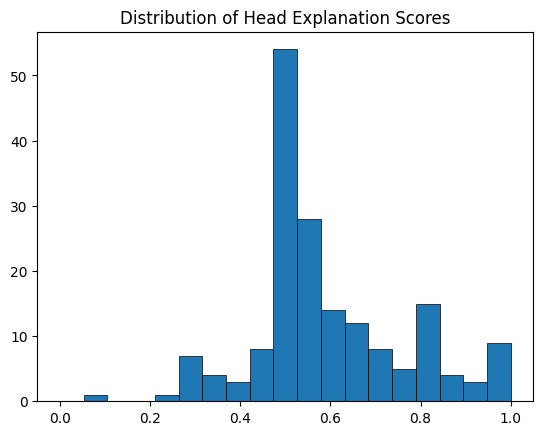

In [11]:
bins = np.linspace(0, 1, 20)
import matplotlib.pyplot as plt
plt.hist(accuracy_balanced.values(), bins, label='Overall Accuracy', linewidth=0.5, edgecolor="black")
plt.title("Distribution of Head Explanation Scores")
plt.savefig("hist.pdf")

In [12]:
print(fig)

NameError: name 'fig' is not defined

In [ ]:
fig.savefig("head_explanation_hist.pdf")

AttributeError: 'tuple' object has no attribute 'savefig'

In [ ]:
x = list(accuracies_positive.values())
y = list(accuracies_negative.values())
print(list(zip(x, y)))
print(list(f1s.values()))

[(0.0, 1.0), (0.0, 1.0), (1.0, 1.0), (0.4, 0.8), (0.4, 0.1), (0.1, 1.0), (0.9, 1.0), (0.2, 0.4), (0.0, 1.0), (0.0, 1.0), (0.0, 1.0), (0.0, 1.0), (0.0, 1.0), (0.8, 0.9), (0.5, 0.8), (0.1, 0.8), (0.9, 1.0), (0.6, 1.0), (0.6, 1.0), (0.6, 0.0), (0.0, 0.9), (0.6, 1.0), (0.2, 1.0), (0.0, 1.0), (0.0, 0.8), (0.2, 0.5), (0.3, 0.8), (0.2, 1.0), (0.3, 0.4), (0.1, 1.0), (0.6, 1.0), (0.1, 1.0), (0.7, 0.9), (0.6, 1.0), (0.7, 0.7), (0.1, 0.8), (0.5, 0.8), (0.6, 0.7), (0.1, 1.0), (0.7, 0.8), (0.7, 0.4), (0.6, 0.8), (0.7, 1.0), (0.8, 0.4), (1.0, 0.3), (0.0, 1.0), (0.0, 1.0), (0.0, 1.0), (0.8, 0.2), (0.3, 0.7), (0.7, 0.9), (0.9, 0.3), (0.5, 0.6), (0.8, 0.7), (0.0, 0.9), (0.4, 0.8), (0.0, 1.0), (0.6, 0.8), (0.9, 0.4), (0.4, 1.0), (0.2, 1.0), (0.5, 0.8), (0.6, 1.0), (0.3, 0.8), (0.0, 1.0), (0.5, 1.0), (0.0, 1.0), (0.1, 1.0), (0.4, 0.2), (0.3, 1.0), (0.0, 1.0), (0.3, 0.8), (0.0, 1.0), (1.0, 0.0), (0.0, 1.0), (0.0, 1.0), (0.2, 0.9), (0.4, 0.8), (0.5, 0.8), (0.6, 0.8), (0.5, 1.0), (0.3, 1.0), (1.0, 0.0), (0.

In [260]:
(grid[6:, 6:].sum() / grid.sum()) * 100

21.59090909090909

[0.0, 0.0, 1.0, 0.4, 0.4, 0.1, 0.9, 0.2, 0.0, 0.0, 0.0, 0.0, 0.0, 0.8, 0.5, 0.1, 0.9, 0.6, 0.6, 0.6, 0.0, 0.6, 0.2, 0.0, 0.0, 0.2, 0.3, 0.2, 0.3, 0.1, 0.6, 0.1, 0.7, 0.6, 0.7, 0.1, 0.5, 0.6, 0.1, 0.7, 0.7, 0.6, 0.7, 0.8, 1.0, 0.0, 0.0, 0.0, 0.8, 0.3, 0.7, 0.9, 0.5, 0.8, 0.0, 0.4, 0.0, 0.6, 0.9, 0.4, 0.2, 0.5, 0.6, 0.3, 0.0, 0.5, 0.0, 0.1, 0.4, 0.3, 0.0, 0.3, 0.0, 1.0, 0.0, 0.0, 0.2, 0.4, 0.5, 0.6, 0.5, 0.3, 1.0, 0.9, 0.6, 0.3, 0.0, 0.1, 0.1, 0.4, 0.3, 0.0, 0.4, 0.0, 0.0, 0.2, 0.0, 0.5, 0.7, 0.0, 0.0, 0.0, 0.3, 1.0, 0.0, 0.0, 0.6, 0.9, 0.7, 0.0, 0.0, 0.9, 0.0, 0.0, 0.0, 0.9, 0.1, 0.0, 1.0, 0.9, 0.8, 0.0, 1.0, 0.5, 0.0, 0.0, 0.7, 1.0, 0.0, 0.0, 0.0, 1.0, 0.2, 0.4, 0.2, 0.3, 1.0, 0.0, 0.2, 0.6, 0.2, 0.7, 0.0, 0.6, 0.0, 1.0, 0.3, 1.0, 0.7, 0.4, 0.0, 0.1, 0.5, 0.45, 0.0, 0.0, 0.0, 0.3, 0.4]
[(0.0, 1.0), (0.0, 1.0), (1.0, 1.0), (0.4, 0.8), (0.4, 0.1), (0.1, 1.0), (0.9, 1.0), (0.2, 0.4), (0.0, 1.0), (0.0, 1.0), (0.0, 1.0), (0.0, 1.0), (0.0, 1.0), (0.8, 0.9), (0.5, 0.8), (0.1, 0.8), (0.9, 1.0)

[Text(0.5, 1.0, 'Distribution of True Positive and True Negative Rates over all heads\n')]

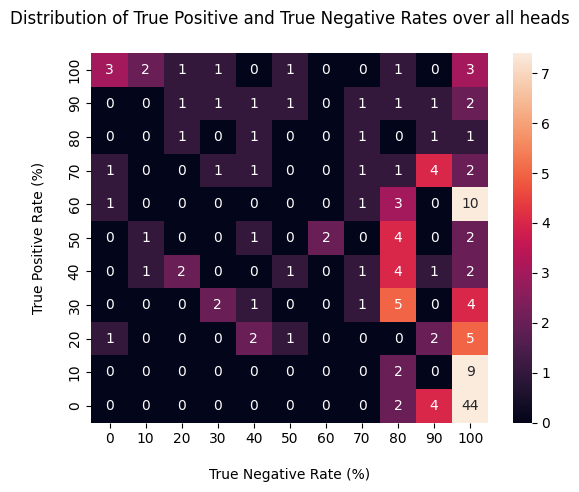

In [261]:

import seaborn as sb

# Create a 2D array filled with zeros
grid = np.zeros((11, 11), dtype=int)
print(x)

# Iterate through the values in x and y
zipped_list = list(zip(x, y))
print(zipped_list)
for x_item, y_item in zipped_list:
    # Iterate through the values in x and y
    # Increment the count in the grid at the corresponding position
    grid[int(x_item*10), int(y_item*10)] +=  1


ax = sb.heatmap(grid, annot=True, robust=True, xticklabels=[i*10 for i in range(11)], yticklabels=[i*10 for i in range(11)])
ax.invert_yaxis()
ax.set(xlabel="\nTrue Negative Rate (%)", ylabel="True Positive Rate (%)\n")
ax.set(title="Distribution of True Positive and True Negative Rates over all heads\n")

In [13]:
tnr = 10
tpr = 10

head_list = []
for head, accuracy_positive in accuracies_positive.items():
    accuracy_negative = accuracies_negative[head]
    if int(accuracy_positive * 10) == tpr and int(accuracy_negative * 10) == tnr:
        head_list.append(head)

print(head_list)
print(len(head_list))


[(31, 3621, 538), (32, 3151, 546), (32, 3151, 496), (34, 4410, 604), (35, 3360, 691), (35, 885, 549)]
6


In [ ]:
print(len(categorised_prompts[(31, 3621, 468)]))

2


In [18]:
def get_head_results(nh, gen_results, nh_to_exp, neuron_to_token, categorised_prompts):
    gen_positive, gen_negative, eval_positive, eval_negative = gen_results[nh]
    balanced_accuracy = accuracy_balanced[nh]

    return_str = f"## {nh} — {balanced_accuracy:.2f} Accuracy \n"
    return_str += f'Neuron helps to predict the token "{neuron_to_token[(nh[0],nh[1])]}".\n'
    positive_egs, negative_egs = categorised_prompts[nh]

    return_str += f"\n### Max-Activating Data from The Pile\n"

    return_str += "Examples where the attention head is active:\n"
    for i, positive_eg in enumerate(positive_egs):
        return_str += f"{i}. {positive_eg}\n"

    return_str += "\nExamples where the attention head is inactive:\n"
    for i, negative_eg in enumerate(negative_egs):
        return_str += f"{i}. {negative_eg}\n"

    return_str += f"\nGPT-4's Explanation: \n   The head is active when the document {nh_to_exp[nh]}\n"

    return_str += f"\n### Synthetic Data from GPT-4\n"

    return_str += "Examples where the attention head is active:\n"
    for i, eg in enumerate(gen_positive):
        return_str += f"{i}. "
        if eg in eval_positive:
            return_str += "✅ "
        else:
            return_str += "❌ "
        return_str += f"{eg}\n"
    return_str += "\nExamples where the attention head is inactive:\n"
    for i, eg in enumerate(gen_negative):
        return_str += f"{i}. "
        if eg in eval_negative:
            return_str += "✅ "
        else:
            return_str += "❌ "
        return_str += f"{eg}\n"
    
    return balanced_accuracy, return_str

accuracy, result = get_head_results(head_list[0], generation_eval, nh_to_explanation, neuron_to_token, categorised_prompts)

print(result)

## (31, 3621, 538) — 1.00 Accuracy 
Neuron helps to predict the token " only".

### Max-Activating Data from The Pile
Examples where the attention head is active:
0.  for one reason and one reason only
1.  site is for informational purposes only
2. known result "$X$ is ${\rm T}_1$ if and only
3.  Software that is described herein is for illustrative purposes only
4.  is intended for general information purposes only
5.  Disclaimer: The Body is designed for educational purposes only
6.  is intended for entertainment purposes only
7.  directory, ("Find A Doctor"), is provided for reference purposes only
8.  this is for informational purposes only

Examples where the attention head is inactive:
0. ire can only work if you are follwoing a proper diet according to your body needs. That is not easy thing for most of the people. To stay healthy, However, It requires you to work hard and stay focused on the end goal. One of the best way to st... moreExcersire can only
1.  becuase we are the on

In [19]:
overview_list = []

for head, accuracy_positive in accuracies_positive.items():
    accuracy, result = get_head_results(head, generation_eval, nh_to_explanation, neuron_to_token, categorised_prompts)
    overview_list.append((accuracy, head, result))

# Sort overview list by first element
overview_list.sort(key=lambda x: x[0], reverse=True)

# Save overview list strings to text file
with open("overview.txt", "w") as f:
    for accuracy, head, result in overview_list:
        f.write(result)
        f.write("\n\n")

In [41]:
ind = 0

In [ ]:
## (31, 3621, 538) — 1.00 Accuracy — for x purposes "only"
## (32, 3151, 546) — 1.00 Accuracy — over and "over"
## (32, 3151, 496) — 1.00 Accuracy — over and "over"
## (34, 4410, 604) — 1.00 Accuracy – as fast/early/high "as"
## (35, 3360, 691) — 1.00 Accuracy — by the "very"... over -> it was very, "very"
## (35, 885, 549) — 1.00 Accuracy — Sentence... "His"
## (31, 364, 548) — 0.95 Accuracy — The number of a document e.g. IMEI "number" passport "number", mobile "number", etc.
## (31, 4378, 123) — 0.95 Accuracy — ... Taken "together"
## (31, 4941, 538) — 0.95 Accuracy — "within" x amount of time
## (34, 5095, 538) — 0.90 Accuracy — working "well", responding "well" — specifically for positive contexts
## (34, 4494, 658) — 0.90 Accuracy — U. S. Pat "no" — specifically for US Patents only
## (34, 4494, 160) — 0.90 Accuracy — U. S. Pat "no" — specifically for US Patents only
## (31, 4378, 538) — 0.85 Accuracy — Bring "together", put two and two "together" — for contexts about merging or joining
## (34, 4494, 641) — 0.90 Accuracy — U. S. Pat "no" — specifically for US Patents only
## (32, 4964, 492) — 0.85 Accuracy — "too" — excessive contexts?
## (35, 5014, 504) — 0.85 Accuracy — " won" — the examples are <won>'t, but GPT-4 doesn't understand that
## (31, 4378, 106) — 0.80 Accuracy — taken "together"
## (31, 4378, 88) — 0.80 Accuracy — taken "together"
## (31, 988, 371) — 0.80 Accuracy — also "called"
## (31, 2692, 559) — 0.80 Accuracy — past vs present e.g. what it "used" to be
## (31, 4941, 466) — 0.80 Accuracy — deadline or timeframe
## (32, 406, 538) — 0.80 Accuracy — ...as "much"
## (33, 4900, 492) — 0.80 Accuracy — a measurement "of"
## (34, 4262, 538) — 0.80 Accuracy — verb "down" e.g. watered down, gunned down
## (34, 4199, 538) — 0.80 Accuracy — sought-" after"

In [74]:
for i, (accuracy, head, result) in enumerate(overview_list):
    if ind != i: 
        continue
    else:
        print(result)
        ind += 1
        break

## (32, 4882, 489) — 0.75 Accuracy 
Neuron helps to predict the token " class".

### Max-Activating Data from The Pile
Examples where the attention head is active:
0.  went to teach a yoga class
1.  evening classes in May 2012, followed by morning class
2.  kind of thing you learn about in introductory general physics class
3.  Science course apart. The once-a-week class
4.  teaching a music-appreciation class
5.  include syllabi and promotional flyers for the first women's studies class
6.  attend gender studies class
7.  general education classroom to do a co-teaching lesson in my classroom. This way I get the opportunity to collaborate with my general education class
8.  am planning on teaching an intro to “Programming for Informaticists” class
9.  not teach headstand in my class

Examples where the attention head is inactive:
0.  teacher who noticed that I was fooling around at the back of the class
1.  an aerobics class
2.  always dabbled. I took a couple soapmaking class
3.  copi

Text(0.5, 1.0, 'Positive Accuracy (Pre_Iteration)')

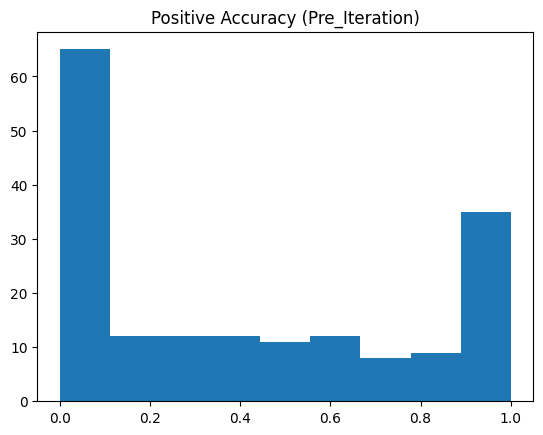

In [84]:
plt.hist(accuracies_positive.values(), bins, label='Positive Accuracy')
plt.title("Positive Accuracy (Pre_Iteration)")

In [63]:
scatter(np.arange(len(accuracies_positive)), list(accuracies_positive.values()), hover_name=labels, title="Accuracy of Positive Generation (Pre-Iteration)",range_y=[-0.1,1.1])

In [64]:
accuracies = []
accuracies_positive = {}
accuracies_negative = []
f1s = []
precisions = []
recalls = []
for head, (pred_pos, pred_neg, correct_pos, correct_neg) in v2.items():
    true_pos = 0
    true_neg = 0
    false_pos = 0
    false_neg = 0
    for eg in pred_pos:
        if eg in correct_pos:
            true_pos += 1
        else:
            false_pos += 1
    for eg in pred_neg:
        if eg in correct_neg:
            true_neg += 1
        else:
            false_neg += 1
    accuracy = (true_pos + true_neg) / (true_pos + true_neg + false_pos + false_neg)
    accuracy_positive = true_pos / (true_pos + false_pos)
    accuracy_negative = true_neg / (true_neg + false_neg)
    precision = true_pos / (true_pos + false_pos)
    try:
        recall = true_pos / (true_pos + false_neg)
        recalls.append(recall)
    except ZeroDivisionError:
        pass
    precisions.append(precision)

    # accuracies_positive.append(accuracy_positive)
    accuracies_positive[head] = accuracy_positive
    accuracies_negative.append(accuracy_negative)
    accuracies.append(accuracy)
    f1 = 2 * true_pos / (2 * true_pos + false_pos + false_neg)
    f1s.append(f1)



print(np.mean(accuracies))
print(np.mean(list(accuracies_positive.values())))
print(np.mean(accuracies_negative))
print(np.mean(f1s))
print(np.mean(precisions))
print(np.mean(recalls))

0.5954229797979799
0.4034090909090909
0.7856534090909091
0.40573377829807455
0.4034090909090909
0.6660497535647056


In [65]:
scatter(np.arange(len(accuracies)), accuracies, title="Overall Accuracy (Post_Iteration)",range_y=[-0.1,1.1])

In [66]:
scatter(np.arange(len(accuracies_positive)), list(accuracies_positive.values()), hover_name=labels, title="Accuracy of Positive Generation (Post-Iteration)", range_y=[-0.1,1.1]) # add hover